# Message passing neural network for segment classification on ACTS data

In this notebook we'll implement a model similar to the Interaction Networks model:
https://arxiv.org/abs/1612.00222

The model will consider a graph of connected hits and try to determine which edges are real and which are spurious.

In [3]:
# Training concurrency
import os
os.environ['OMP_NUM_THREADS'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

cuda = False

In [4]:
%load_ext autoreload
%autoreload 2

# System imports
from __future__ import print_function
import os
import multiprocessing as mp
from timeit import default_timer as timer

# Externals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.model_selection import train_test_split

# Torch imports
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

# Local imports
from estimator import Estimator
from acts import process_hits_files, select_barrel_hits

%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
if cuda:
    np_to_torch = lambda x, volatile=False: (
        Variable(torch.from_numpy(x.astype(np.float32)), volatile=volatile).cuda())
else:
    np_to_torch = lambda x, volatile=False: (
        Variable(torch.from_numpy(x.astype(np.float32)), volatile=volatile))

torch_to_np = lambda x: x.cpu().data.numpy()

## Data utilities

In [21]:
def select_hits(hits):
    # Select all barrel hits
    vids = [8, 13, 17]
    hits = hits[np.logical_or.reduce([hits.volid == v for v in vids])]
    # Re-enumerate the volume and layer numbers for convenience
    volume = pd.Series(-1, index=hits.index, dtype=np.int8)
    vid_groups = hits.groupby('volid')
    for i, v in enumerate(vids):
        volume[vid_groups.get_group(v).index] = i
    # This assumes 4 layers per volume (except last volume)
    layer = (hits.layid / 2 - 1 + volume * 4).astype(np.int8)
    # Select the columns we need
    hits = (hits[['evtid', 'barcode', 'r', 'phi', 'z']]
            .assign(volume=volume, layer=layer))
    # Filter tracks that hit every layer
    hits = (hits.groupby(['evtid', 'barcode'])
            .filter(lambda x: len(x.layer.unique()) == 10))
    # Remove duplicate hits
    hits = hits.loc[
        hits.groupby(['evtid', 'barcode', 'layer'], as_index=False).r.idxmin()
    ]
    return hits

## Prepare the data

In [22]:
input_dir = '/data/ntran/prod_mu10_pt1000_2017_07_29'

In [23]:
all_files = os.listdir(input_dir)
hits_files = sorted(f for f in all_files if f.startswith('clusters'))

n_files = 1
hits_files = [os.path.join(input_dir, hf) for hf in hits_files[:n_files]]

In [26]:
%%time

n_workers = 2
with mp.Pool(processes=n_workers) as pool:
    hits = process_hits_files(hits_files, pool)
    print('Applying selections')
    hits = pool.map(select_hits, hits)

# Concatenate everything together
hits = pd.concat(hits, ignore_index=True)

Loading /data/ntran/prod_mu10_pt1000_2017_07_29/clusters_1.csv
Applying selections
CPU times: user 108 ms, sys: 75.7 ms, total: 183 ms
Wall time: 1min 1s


### Construct the dataset

In [27]:
# Select the particle keys
particle_keys = hits[['evtid', 'barcode']].drop_duplicates().values
np.random.shuffle(particle_keys)
particle_keys.shape

(13499, 2)

In [28]:
# Data config
n_tracks = 10
n_samples = particle_keys.shape[0] // n_tracks
feature_names = ['r', 'phi', 'z']
n_features = len(feature_names)
feature_scale = np.array([1000., np.pi, 1000.])
print('Preparing', n_samples, 'samples with', n_tracks, 'tracks each')
assert n_samples <= (particle_keys.shape[0] // n_tracks), 'Not enough tracks!'

Preparing 1349 samples with 10 tracks each


In [29]:
# Fixed number of hits and edges per sample in this dataset
n_det_layers = hits.layer.unique().shape[0]
n_hits = n_tracks * n_det_layers
n_edges = n_tracks**2 * (n_det_layers - 1)
edge_idx = np.arange(n_edges)
n_hits, n_edges

(100, 900)

In [30]:
# Pre-allocate the dataset storage
full_X = np.zeros((n_samples, n_hits, n_features))
full_Ri = np.zeros((n_samples, n_hits, n_edges), dtype=np.uint8)
full_Ro = np.zeros((n_samples, n_hits, n_edges), dtype=np.uint8)
full_y = np.zeros((n_samples, n_edges), dtype=np.uint8)

In [31]:
%%time

sig_groups = hits.groupby(['evtid', 'barcode'])

# Loop over samples
for i in range(n_samples):
    # Pick out the particles for this sample
    sample_keys = particle_keys[i*n_tracks:(i+1)*n_tracks]
    sample_hits = pd.concat([sig_groups.get_group(tuple(k)) for k in sample_keys])

    # Select adjacent-layer hit pairs.
    sample_layers = sample_hits.layer.values
    adj_idx = np.stack(np.where((sample_layers[None,:] - sample_layers[:,None]) == 1), axis=1)
    
    # Fill the adjacency matrices
    full_Ri[i, adj_idx[:,1], edge_idx] = 1
    full_Ro[i, adj_idx[:,0], edge_idx] = 1
    
    # Fill the node features
    full_X[i] = sample_hits[feature_names].values / feature_scale
    
    # Fill the edge labels
    barcodes = sample_hits.barcode.values
    bc_in = np.matmul(barcodes[None], full_Ri[i]).squeeze(0)
    bc_out = np.matmul(barcodes[None], full_Ro[i]).squeeze(0)
    full_y[i] = (bc_in == bc_out)

CPU times: user 5 s, sys: 24.5 ms, total: 5.02 s
Wall time: 5.01 s


### Visualize one sample

Need to put this code into a function, and write it so it will be easy to use
at model evaluation time (e.g., using model representation of the data).

In [32]:
def draw_sample(X, Ri, Ro, y, cmap='bwr_r', alpha_labels=False):
    """
    TODO: make segment coloring configurable.
    """
    # Select the i/o node features for each segment
    feats_o = X[np.where(Ri.T)[1]]
    feats_i = X[np.where(Ro.T)[1]]
    # Prepare the figure
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9,4))
    cmap = plt.get_cmap(cmap)
    
    # Draw the hits (r, phi, z)
    ax0.scatter(X[:,2], X[:,0], c='k')
    ax1.scatter(X[:,1], X[:,0], c='k')
    
    # Draw the segments
    for j in range(y.shape[0]):
        if alpha_labels:
            seg_args = dict(c='k', alpha=float(y[j]))
        else:
            seg_args = dict(c=cmap(float(y[j])))
        ax0.plot([feats_o[j,2], feats_i[j,2]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
        ax1.plot([feats_o[j,1], feats_i[j,1]],
                 [feats_o[j,0], feats_i[j,0]], '-', **seg_args)
    # Adjust axes
    #ax0.set_xlim(-1100, 1100)
    ax1.set_xlim(-np.pi, np.pi)
    ax0.set_xlabel('$z$ [mm]')
    ax1.set_xlabel('$\phi$ [rad]')
    ax0.set_ylabel('$r$ [mm]')
    ax1.set_ylabel('$r$ [mm]')
    plt.tight_layout()

<IPython.core.display.Javascript object>


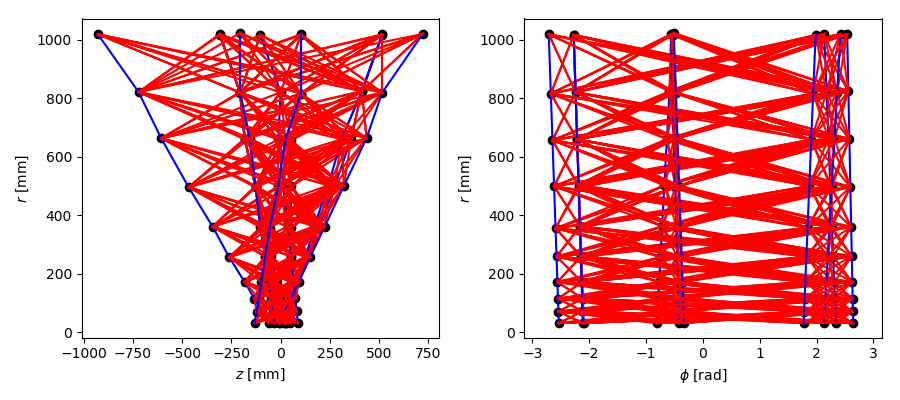

In [33]:
# Choose a sample to draw
i = 0
X = full_X[i] * feature_scale
Ri, Ro = full_Ri[i], full_Ro[i]
y = full_y[i]

draw_sample(X, Ri, Ro, y)

## Define the model

In [9]:
class EdgeNetwork(nn.Module):
    """
    A module which computes weights for edges of the graph.
    For each edge, it selects the associated nodes' features
    and applies some fully-connected network layers with a final
    sigmoid activation.
    """
    def __init__(self, input_dim, hidden_dim=8, hidden_activation=nn.Tanh):
        super(EdgeNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim*2, hidden_dim),
            hidden_activation(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid())
    def forward(self, X, Ri, Ro):
        # Select the features of the associated nodes
        bo = torch.matmul(Ro.transpose(1, 2), X)
        bi = torch.matmul(Ri.transpose(1, 2), X)
        B = torch.cat([bo, bi], dim=2)
        # Apply the network to each edge
        return self.network(B).squeeze(-1)

class NodeNetwork(nn.Module):
    """
    A module which computes new node features on the graph.
    For each node, it aggregates the neighbor node features
    (separately on the input and output side), and combines
    them with the node's previous features in a fully-connected
    network to compute the new features.
    """
    def __init__(self, input_dim, output_dim, hidden_activation=nn.Tanh):
        super(NodeNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim*3, output_dim),
            hidden_activation(),
            nn.Linear(output_dim, output_dim),
            hidden_activation())
    def forward(self, X, e, Ri, Ro):
        bo = torch.matmul(Ro.transpose(1, 2), X)
        bi = torch.matmul(Ri.transpose(1, 2), X)
        Rwo = Ro * e[:,None]
        Rwi = Ri * e[:,None]
        mi = torch.matmul(Rwi, bo)
        mo = torch.matmul(Rwo, bi)
        M = torch.cat([mi, mo, X], dim=2)
        return self.network(M)

class SegmentClassifier(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=8, n_iters=3, hidden_activation=nn.Tanh):
        super(SegmentClassifier, self).__init__()
        self.n_iters = n_iters
        # Setup the input network
        self.input_network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            hidden_activation())
        # Setup the edge network
        self.edge_network = EdgeNetwork(input_dim+hidden_dim, hidden_dim, hidden_activation)
        # Setup the node layers
        self.node_network = NodeNetwork(input_dim+hidden_dim, hidden_dim, hidden_activation)

    def forward(self, inputs):
        """Apply forward pass of the model"""
        X, Ri, Ro = inputs
        # Apply input network to get hidden representation
        H = self.input_network(X)
        # Shortcut connect the inputs onto the hidden representation
        H = torch.cat([H, X], dim=-1)
        # Loop over iterations of edge and node networks
        for i in range(self.n_iters):
            # Apply edge network
            e = self.edge_network(H, Ri, Ro)
            # Apply node network
            H = self.node_network(H, e, Ri, Ro)
            # Shortcut connect the inputs onto the hidden representation
            H = torch.cat([H, X], dim=-1)
        # Apply final edge network
        return self.edge_network(H, Ri, Ro)

## Train the model

In [34]:
# Develop a batch generator here
def batch_generator(X, Ri, Ro, y, n_samples=1, batch_size=1, train=True):
    volatile = not train
    batch_idxs = np.arange(0, n_samples, batch_size)
    # Loop over epochs
    while True:
        # Loop over batches
        for j in batch_idxs:
            batch_X = np_to_torch(X[j:j+batch_size], volatile=volatile)
            batch_Ri = np_to_torch(Ri[j:j+batch_size], volatile=volatile)
            batch_Ro = np_to_torch(Ro[j:j+batch_size], volatile=volatile)
            batch_y = np_to_torch(y[j:j+batch_size], volatile=volatile)
            batch_inputs = [batch_X, batch_Ri, batch_Ro]
            yield batch_inputs, batch_y

In [35]:
# Model config
hidden_dim = 32
n_iters = 4

# Training config
batch_size = 32
n_epochs = 32
valid_frac = 0.2
test_frac = 0.2

In [36]:
# We round by batch_size to avoid partial batches
n_test = int(n_samples * test_frac) // batch_size * batch_size
n_valid = int(n_samples * valid_frac) // batch_size * batch_size
n_train = (n_samples - n_valid - n_test) // batch_size * batch_size
n_train_batches = n_train // batch_size
n_valid_batches = n_valid // batch_size
n_test_batches = n_test // batch_size

n_train, n_valid, n_test, n_train + n_valid + n_test

(832, 256, 256, 1344)

In [37]:
# Partition the dataset
(train_X, test_X, train_Ri, test_Ri, train_Ro, test_Ro, train_y, test_y) = (
    train_test_split(full_X, full_Ri, full_Ro, full_y, test_size=n_test))
(train_X, valid_X, train_Ri, valid_Ri, train_Ro, valid_Ro, train_y, valid_y) = (
    train_test_split(train_X, train_Ri, train_Ro, train_y, test_size=n_valid))

In [38]:
print('Train shapes:', train_X.shape, train_Ri.shape, train_Ro.shape, train_y.shape)
print('Valid shapes:', valid_X.shape, valid_Ri.shape, valid_Ro.shape, valid_y.shape)
print('Test shapes: ', test_X.shape, test_Ri.shape, test_Ro.shape, test_y.shape)

Train shapes: (837, 100, 3) (837, 100, 900) (837, 100, 900) (837, 900)
Valid shapes: (256, 100, 3) (256, 100, 900) (256, 100, 900) (256, 900)
Test shapes:  (256, 100, 3) (256, 100, 900) (256, 100, 900) (256, 900)


In [39]:
# Prepare the batch generators
train_batcher = batch_generator(train_X, train_Ri, train_Ro, train_y,
                                n_samples=n_train, batch_size=batch_size)
valid_batcher = batch_generator(valid_X, valid_Ri, valid_Ro, valid_y, train=False,
                                n_samples=n_valid, batch_size=batch_size)
test_batcher = batch_generator(test_X, test_Ri, test_Ro, test_y, train=False,
                               n_samples=n_test, batch_size=batch_size)

In [40]:
# Construct the model
model = SegmentClassifier(input_dim=n_features, hidden_dim=hidden_dim, n_iters=n_iters)
loss_func = nn.BCELoss()
estim = Estimator(model, loss_func=loss_func, cuda=cuda)

2018-07-05 16:03:42.053115 Model: 
SegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=70, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
      (3): Sigmoid()
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=105, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Tanh()
    )
  )
)
2018-07-05 16:03:42.053423 Parameters: 6881


In [44]:
estim.fit_gen(train_batcher, n_batches=n_train_batches, n_epochs=n_epochs,
              valid_generator=valid_batcher, n_valid_batches=n_valid_batches, 
              filename='model2/checkpoint.pt')

2018-07-05 16:05:02.643049 Epoch 27
2018-07-05 16:05:07.469941   training loss 0.261 time 4.82646s


/home/sjenkins/miniconda3/envs/pytorch-training/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


2018-07-05 16:05:08.061755   validate loss 0.261
2018-07-05 16:05:08.061840  save checkpoint
2018-07-05 16:05:08.063785 Epoch 28
2018-07-05 16:05:12.862267   training loss 0.26 time 4.79842s
2018-07-05 16:05:13.452131   validate loss 0.26
2018-07-05 16:05:13.452232  save checkpoint
2018-07-05 16:05:13.454635 Epoch 29
2018-07-05 16:05:18.227004   training loss 0.258 time 4.7723s
2018-07-05 16:05:18.820635   validate loss 0.258
2018-07-05 16:05:18.820722  save checkpoint
2018-07-05 16:05:18.823285 Epoch 30
2018-07-05 16:05:23.497448   training loss 0.257 time 4.67399s
2018-07-05 16:05:24.071815   validate loss 0.258
2018-07-05 16:05:24.071890  save checkpoint
2018-07-05 16:05:24.074068 Epoch 31
2018-07-05 16:05:28.616330   training loss 0.257 time 4.54219s
2018-07-05 16:05:29.184282   validate loss 0.258
2018-07-05 16:05:29.184354  save checkpoint
2018-07-05 16:05:29.186601 Epoch 32
2018-07-05 16:05:33.746930   training loss 0.256 time 4.56017s
2018-07-05 16:05:34.323715   validate loss 

KeyboardInterrupt: 

In [42]:
estim.load_checkpoint('Models/checkpoint.pt')

### Loss curves

<IPython.core.display.Javascript object>


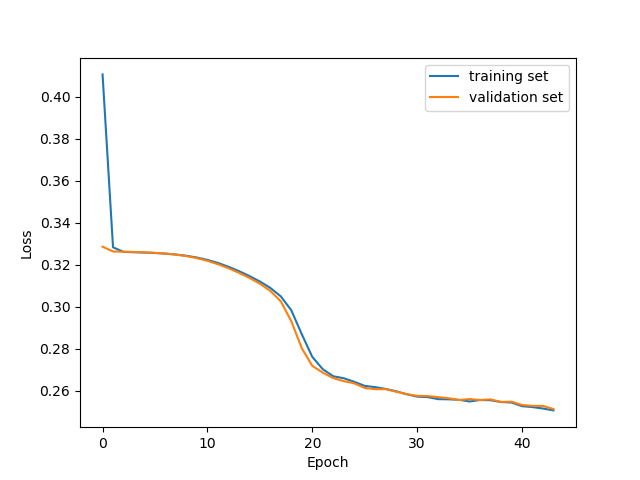

In [45]:
# Plot the loss
plt.figure()
plt.plot(estim.train_losses, label='training set')
plt.plot(estim.valid_losses, label='validation set')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc=0);

## Evaluate model on the test set

In [ ]:
test_pred = torch_to_np(estim.predict(test_batcher, n_test_batches))

In [ ]:
flat_y = test_y.flatten()
flat_pred = test_pred.flatten()
thresh = 0.5

print('Test set results with threshold of', thresh)
print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(flat_y, flat_pred>thresh))
print('Precision: %.4f' % sklearn.metrics.precision_score(flat_y, flat_pred>thresh))
print('Recall:    %.4f' % sklearn.metrics.recall_score(flat_y, flat_pred>thresh))

In [ ]:
# Compute the ROC curve
fpr, tpr, _ = sklearn.metrics.roc_curve(flat_y, flat_pred)

In [ ]:
plt.figure(figsize=(9,4))

# Plot the model outputs
plt.subplot(121)
binning=dict(bins=50, range=(0,1), histtype='bar')
plt.hist(flat_pred[flat_y<0.5], label='fake', **binning)
plt.hist(flat_pred[flat_y>0.5], label='true', **binning)
plt.xlabel('Model output')
plt.legend(loc=0)

# Plot the ROC curve
plt.subplot(122)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

plt.tight_layout()

## Visualize some samples

In [ ]:
# Draw some samples
for i in range(4):
    print('accuracy %.3f, precision %.3f, recall %.3f' % (
        sklearn.metrics.accuracy_score(test_y[i], test_pred[i]>thresh),
        sklearn.metrics.precision_score(test_y[i], test_pred[i]>thresh),
        sklearn.metrics.recall_score(test_y[i], test_pred[i]>thresh)))
    draw_sample(test_X[i]*feature_scale, test_Ri[i], test_Ro[i], test_pred[i], alpha_labels=True);

## Visualize evolution of graph iterations

Let's take a sample and pull out the intermediate edge scores during graph iterations.
I'd like to visualize how the model converges on its chosen edges.

In [ ]:
def graph_iter(model, X, H, Ri, Ro):
    # Shortcut connections
    H = torch.cat([H, X], dim=-1)
    # Edge network
    e = model.edge_network(H, Ri, Ro)
    # Node network
    H = model.node_network(H, e, Ri, Ro)
    return e, H

In [ ]:
batcher = batch_generator(test_X, test_Ri, test_Ro, test_y, train=False,
                          n_samples=1, batch_size=1)

In [ ]:
model = estim.model

In [ ]:
# Pull the inputs from the batcher
(X, Ri, Ro), y = next(batcher)

In [ ]:
# Apply input network
H = model.input_network(X)

for i in range(model.n_iters + 1):
    # Apply an iteration of the graph
    e, H = graph_iter(model, X, H, Ri, Ro)

    # Draw the edges
    draw_sample(torch_to_np(X)[0]*feature_scale,
                torch_to_np(Ri)[0], torch_to_np(Ro)[0],
                torch_to_np(e)[0], alpha_labels=True)

## Discussion

On 10 tracks and 10 barrel layers, the performance is great!